# Exercise 1 - 3D - 2D

In [1]:
import numpy as np
import cv2 as cv2
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt

Recall from the slides the steps from Algorithm 3:

![title](algorithm_3.png)

![title](PnP.png)

# Exercise 1a)
The steps 1)-2.1) has already been done, and is saved in corresponding files. The exercise is to implement step 2.2) by filling in the missing code below

In [23]:
def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCV to find the prev_points from the prev_img in the next_img
    Remember to remove points that could not be found from prev_points, next_points, and world_points
    hint: status == 1
    """
    params = dict(winSize=(21, 21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, None, **params)

    #Convert status array to 1D array
    status = np.array(status==1).ravel()

    # Remove points that could not be found
    prev_points = prev_points[status == 1]
    next_points = next_points[status == 1]
    world_points = world_points[status == 1]


    return world_points, prev_points, next_points

Hint: Exercise 4 in week 2

# Exercise 1b)
Continue the algorithm by implementing step 2.3)

In [24]:
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02], # camera matrix
              [0, 7.188560e+02, 1.852157e+02],
              [0, 0, 1]])

reference_img = np.load("img_" + str(0) + ".npy")

for t in range(1, 6):

    # the image at current time=t
    curImage = np.load("img_" + str(t) + ".npy")
    # the 3D landmarks in the world coordinates which have been computed in time=t-1
    landmark_3D = np.load("landmark_" + str(t-1) + ".npy")
    # the 2D coordinates of the 3D points in the previous frame at time=t-1
    reference_2D = np.load("reference_2D_" + str(t-1) + ".npy")


    
    # the 2D landmarks at the current time = t
    landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(reference_img, 
                                                                  curImage, 
                                                                  reference_2D,
                                                                  landmark_3D)
    
    """
    Using OpenCV, implement PnP using Ransac
    """
    _, rvec, tvec, inliers = cv2.solvePnPRansac(landmark_3D, tracked_2Dpoints, K, None)


    """
    Transform the translation and rotation into the world frame
    """
    R, _ = cv2.Rodrigues(rvec)
    tvec = -R.T @ tvec
    
    print(tvec[0], tvec[1], tvec[2], rvec[0], rvec[1], rvec[2])

    # update for next timestep
    reference_img = curImage

[-0.00110282] [-0.00067164] [-0.00078343] [-7.40069215e-05] [-7.35119066e-05] [9.84544281e-05]
[-0.00363949] [-0.00875088] [0.67580836] [-0.00216658] [0.00325854] [-0.00244333]
[-0.01096317] [-0.01635688] [1.37740874] [-0.00364614] [0.00751509] [-0.00099692]
[-0.03156638] [-0.02560108] [2.09967983] [-0.00509583] [0.01121646] [-0.00082978]
[-0.04971864] [-0.03532535] [2.83300707] [-0.00561424] [0.0161333] [0.00041981]


Hint: The output should look similar to:

[-0.00110282] [-0.00067164] [-0.00078343] [-7.40069212e-05] [-7.35119065e-05] [9.84544279e-05]

[-0.00363946] [-0.00875075] [0.67580842] [-0.0021666] [0.00325853] [-0.00244333]

[-0.01096271] [-0.01635663] [1.3774094] [-0.00364615] [0.0075151] [-0.00099691]

[-0.0315663] [-0.02560111] [2.0996797] [-0.00509583] [0.01121646] [-0.00082978]

[-0.04971858] [-0.03532535] [2.8330071] [-0.00561424] [0.0161333] [0.00041981]

# Exercise 1c)
What approximate direction did the camera move in?

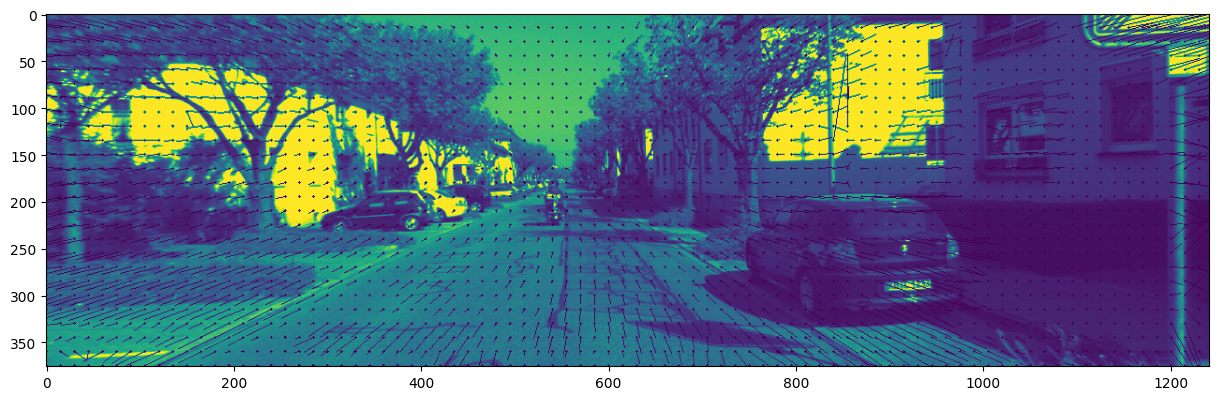

In [32]:

#convert npy to png
for i in range(6):
    img = np.load("img_" + str(i) + ".npy")
    cv2.imwrite("img_" + str(i) + ".png", img)


#import png images as grayscale
gray1 = cv2.imread("img_0.png", 0)
gray2 = cv2.imread("img_2.png", 0)

flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)


mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Retrieving the magnitude and angle of every pixel

### Fill in some code to represent the flow here ###

# Drawing the flow field as arrows on the image
h, w = gray2.shape[:2]
y, x = np.mgrid[0:h:15, 0:w:15].reshape(2,-1).astype(int)
fx, fy = flow[y,x].T

# Create line endpoints
lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
lines = np.int32(lines)

# Create image and draw
vis = curImage.copy()
for (x1, y1), (x2, y2) in lines:
    cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 1)
    cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)

plt.figure(figsize=(15,15))
plt.imshow(vis)